In [1]:
import warnings
warnings.filterwarnings('ignore')

from tifffile import imread, imwrite
import ast
import os
from glob import glob

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycocotools.mask as rletools
import tifffile
from scipy.ndimage import zoom
from skimage.segmentation import relabel_sequential
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap

from EmbedSeg.train import invert_one_hot
from EmbedSeg.utils.glasbey import Glasbey

In [2]:
# Function to plot slices of a 3D image (code adapated from EmbedSeg)
# https://github.com/juglab/EmbedSeg/

def visualize_3d_custom(
    im_filename, pred_filename, new_cmp, pixel
):
    """
    Parameters
    -------
    im_filename: str

    pred_filename: str

    new_cmp: color map

    Returns
    -------

    """
    font = {
        "family": "serif",
        "color": "black",
        "weight": "bold",
        "size": 16,
    }
    fig = plt.figure(constrained_layout=False, figsize=(8, 10))
    # rows represent three views of the sstack.
    # cols represent the image, center and label
    spec = gridspec.GridSpec(ncols=3, nrows=4, figure=fig)
    im = tifffile.imread(im_filename)
    pred_label, _, _ = relabel_sequential(tifffile.imread(pred_filename))

    new_anisotropy_z = im.shape[2] / im.shape[0]
    new_anisotropy_x = im.shape[2] / im.shape[1]

    anisotropy_z = new_anisotropy_z
    anisotropy_x = new_anisotropy_x
    im = zoom(im, (anisotropy_z, anisotropy_x, 1), order=0)

    pred_label = zoom(pred_label, (anisotropy_z, anisotropy_x, 1), order=0)

    z_mid = im.shape[0] // 2
    y_mid = im.shape[1] // 2
    x_mid = im.shape[2] // 2

    ax0 = fig.add_subplot(spec[0, 0])
    ax0.imshow(im[z_mid, ...], cmap="magma", interpolation="None")
    ax0.set_yticklabels([])
    ax0.set_yticks([])
    ax0.set_xticklabels([])
    ax0.set_xticks([])
    ax0.set_ylabel("IM", fontdict=font)
    ax0.set_xlabel("xy", fontdict=font)
    ax0.xaxis.set_label_position("top")
    scalebar = ScaleBar(pixel, "um", length_fraction=0.1, location="lower right")
    ax0.add_artist(scalebar)

    
    ax2 = fig.add_subplot(spec[1, 0])
    ax2.imshow(pred_label[z_mid, ...], cmap=new_cmp, interpolation="None")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.set_ylabel("PRED", fontdict=font)

    # use interpolation
    ax8 = fig.add_subplot(spec[0, 1])
    ax8.imshow(im[..., x_mid], cmap="magma", interpolation="None")
    ax8.set_yticklabels([])
    ax8.set_yticks([])
    ax8.set_xticklabels([])
    ax8.set_xticks([])
    ax8.set_xlabel("yz", fontdict=font)
    scalebar2 = ScaleBar(pixel, "um", length_fraction=0.1, location="lower right")
    ax8.add_artist(scalebar2)

    ax8.xaxis.set_label_position("top")


    ax10 = fig.add_subplot(spec[1, 1])
    ax10.imshow(pred_label[..., x_mid], cmap=new_cmp, interpolation="None")
    ax10.axes.get_xaxis().set_visible(False)
    ax10.set_yticklabels([])
    ax10.set_yticks([])

    ax4 = fig.add_subplot(spec[0, 2])
    ax4.imshow(np.transpose(im[:, y_mid, ...]), cmap="magma", interpolation="None")
    ax4.set_yticklabels([])
    ax4.set_yticks([])
    ax4.set_xticklabels([])
    ax4.set_xticks([])
    ax4.set_xlabel("zx", fontdict=font)
    scalebar3 = ScaleBar(pixel, "um", length_fraction=0.1, location="lower right")
    ax4.add_artist(scalebar3)

    ax4.xaxis.set_label_position("top")


    ax6 = fig.add_subplot(spec[1, 2])
    ax6.imshow(
        np.transpose(pred_label[:, y_mid, ...]), cmap=new_cmp, interpolation="None"
    )
    ax6.axes.get_xaxis().set_visible(False)
    ax6.set_yticklabels([])
    ax6.set_yticks([])

    plt.tight_layout(pad=0, h_pad=0)
    plt.show()


In [3]:
new_cmp= np.load('/mnt/home/dkim1/EmbedSeg/cmaps/cmap_60.npy')
new_cmp = ListedColormap(new_cmp)

### Source (Training) data: {Mouse embryo A, B from Hiiragi group} 
### Target (Testing) data: {Mouse-Organoid-Cells-CBG}


## Predicted segmentations from model trained using 1 non-style transferred small target dataset


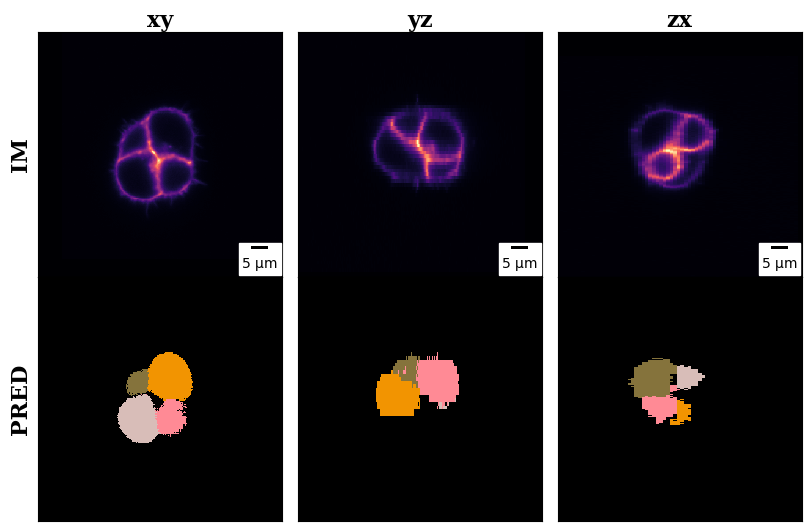

In [4]:
save_dir = "/mnt/home/dkim1/EmbedSeg/examples/3d/TL-Hiiragi/target-bl-3/"

prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
image_file_names = sorted(glob(os.path.join('/mnt/home/dkim1/ceph/EmbedSeg/Mouse-Organoid-Cells-CBG/', 'test', 'images','*.tif')))
prediction_file_names = prediction_file_names[:1]
image_file_names = image_file_names[:1]

for index in range(len(image_file_names)):
    visualize_3d_custom(image_file_names[index], prediction_file_names[index], new_cmp, 0.1733)

## Predicted segmentations from model trained using 2 style transferred source datasets


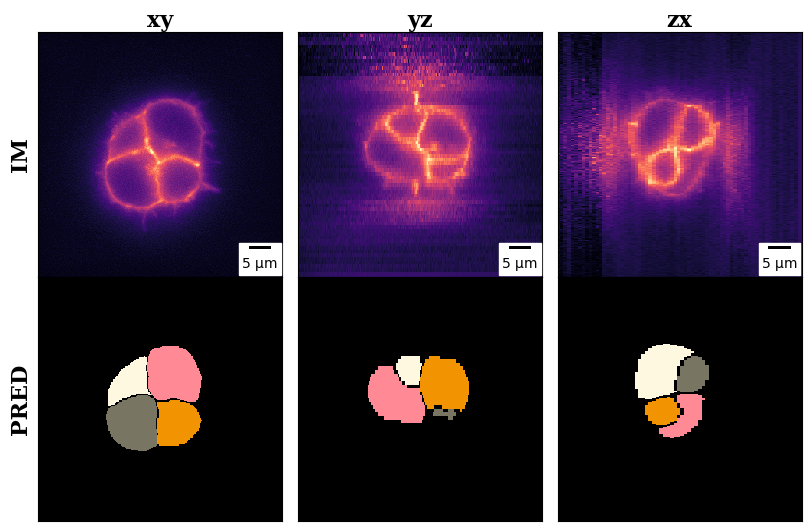

In [5]:
save_dir = "/mnt/home/dkim1/EmbedSeg/examples/3d/TL-Hiiragi/2dl-st_test/"

prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
image_file_names = sorted(glob(os.path.join('/mnt/home/dkim1/ceph/StyleID/ContentMO_StyleD6/', 'test', 'images','*.tif')))
prediction_file_names = prediction_file_names[:1]
image_file_names = image_file_names[:1]

for index in range(len(image_file_names)):
    visualize_3d_custom(image_file_names[index], prediction_file_names[index], new_cmp, 0.1733)